- competition/dataset : [https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data)
- date : 2021/03/24
- original : [https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras](https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras)

## [For Beginners] Tackling Toxic Using Keras

**✏ 필사 1회** 

이 노트북은 Keras LSTM을 사용하여 이 분류 문제를 해결하고자 합니다. 많은 노트북들이 이미 이 접근 방법을 사용하여 해결하고 있으나 각 단계마다 진행되는 작업에 대한 설명이 충분하지 않다고 느낍니다. vanilla Tensorflow를 사용하고 최근에는 Keras의 멋진 세계를 받아들인 사람으로서 연구와 공부를 통해 내가 얻은 직관력을 동료 초보자들과 공유하기 원합니다.

In [28]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [29]:
# Loading the train and test files
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [30]:
# a sneak peek at the training and testing dataset
train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


일반적인 전처리 단계는 결측값을 확인하고 다음 단계로 넘어가기 전에 결측값을 채우는 것입니다. 만약 결측값을 그대로 두고 넘어간다면 이후에 모델링 단계에서 우리를 괴롭힐 것입니다.

In [31]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [32]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

결측값을 다룰 필요가 없어 보입니다!  

데이터 셋에 대해 수행할 수 있는 수많은 전처리와 feature engineering 단계가 있지만 오늘 우리의 목적은 전처리가 아니기 때문에 여기서 우리가 하고 있는 것은 남은 단계들을 잘 작동시킬 수 있는 최소한의 전처리입니다.  

위에서 잠시 봤던 것처럼 종속 변수들은 트레이닝 셋 자체에 있기 때문에 이들을 X와 Y 셋으로 나눠야 합니다.

In [33]:
list_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[list_classes].values
list_sentences_train = train['comment_text']
list_sentences_test = test['comment_text']

우리가 취하고 있는 접근 방법은 신경망 일부에 LSTM의 의견을 전달하는 것이지만 단어를 그대로 전달할 수는 없습니다.  

따라서 우리가 해야할 것들은 다음과 같습니다:  
1. Tokenization - 문장을 고유 단어들로 쪼개야 합니다. 예를 들어 'I love cats and love dogs'는 ['I', 'love', 'cats', 'and', 'dogs']가 될 것입니다.  
2. Indexing - 단어를 딕셔너리와 같은 구조에 넣고 각각에 인덱스를 주어야 합니다. ({1:'I', 2:'love', 3:'cats', 4:'and', 5:'dogs'}
3. Index Representation - 단어의 순서를 인덱스 형태의 코멘트로 나타낼 수 있으며, 우리의 LSTM에 인덱스 체인을 입력할 수 있습니다. ([1, 2, 3, 4, 2, 5])

다행히도, Keras는 이것들을 매우 쉽게 해줍니다. vanilla Tensorflow를 사용했다면 아마도 딕셔너리 형태를 직접 구현하고 인덱싱도 직접 다루어야 할 것입니다. Keras에서는 위의 모든 단계가 단 네 줄의 코드로 완성될 수 있습니다. 문장을 토큰화할 때 고유한 단어의 수를 정의해야 합니다.

In [34]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

또한 딕셔너리에서 각 단어의 발생과 색인도 살펴볼 수 있습니다.

In [35]:
# 단어
# tokenizer.word_counts
# 인덱스
# tokenizer.word_index

list_tokenized_train을 살펴보면 Keras가 단어를 인덱스 형태로 바꾼 것을 볼 수 있습니다.

In [36]:
list_tokenized_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

그러나 여전히 한 가지 문제점이 있습니다. 일부 코멘트는 끔찍하게 긴 반면 어떤 단어는 그저 한 글자라면 어떨까요? 다음과 같은 경우가 있습니다:  

Comment #1: [8, 9, 3, 7, 3, 6, 3, 6, 3, 6, 2, 3, 4, 9]  
Comment #2: [1, 2]  

또한 일관된 길이(고정된 수의 feature)를 가진 데이터 스트림을 제공해야 합니다.  

이것이 padding을 사용하는 이유입니다. 0으로 부족한 부분을 채워 짧은 문장을 다른 문장의 길이로 만들어 줄 수 있습니다. 그러나 반대로 긴 문장도 긴 것은 짧은 것과 같은 길이로 잘라야 합니다. 이 경우에 우리는 max length를 200으로 설정합니다.

In [37]:
maxlen = 200
x_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
x_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

최적의 maxlen은 어떻게 알 수 있을까요? 너무 짧은 값을 넣게 되면, 유용한 feature를 잃어 정확도가 떨어질 수 있습니다. 반대로 너무 긴 값을 넣으면, LSTM 셀이 더 커야 가능한 값이나 상태를 저장할 수 있습니다.  

그 방법을 찾는 방법 중 하나는 문장 내 단어의 수의 분포를 보는 것입니다.

In [38]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

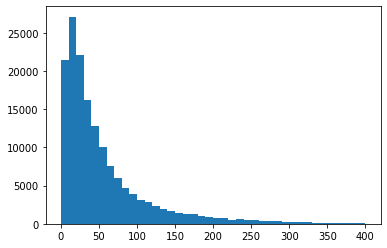

In [39]:
plt.hist(totalNumWords, bins=np.arange(0, 410, 10))
plt.show()

대부분 문장의 길이는 30 정도입니다. maxlen을 50으로 설정할 수도 있습니다. 실험해보면서 마법의 숫자가 무엇인지 찾을 수 있습니다.

### Finally the start of building our model!
다음은 우리가 구축하고자 하는 모델의 구조입니다. 모델의 각 레이어의 차원을 나열하여 시각적으로 생각하고 이후에 디버깅에 도움이 될 수 있도록 하는 것이 좋습니다.  
![](data/txJomEa.png)  

#### Input Layer
이전에도 언급했던 것처럼 우리 네트워크의 입력은 인코딩된 문장의 리스트입니다. 우선 차원이 200인 문장 리스트를 받는 입력 레이어를 정의합니다.

In [40]:
# 콤마 이후에 공백은 keras가 자동으로 연산하게 하기 위함
inp = Input(shape=(maxlen,))

#### Embedding Layer

그 다음 임베딩 레이어로 전달하여 문장 내 주변 단어의 거리에 따라 단어를 벡터 공간에 투영합니다. 임베딩은 모델 크기와 문장의 단어를 나타내기 위해 one-hot encoding을 사용한 경우 다뤄야 하는 거대한 차원을 줄일 수 있습니다.  

임베딩 레이어의 출력은 벡터 공간의 단어의 좌표 리스트입니다. 예를 들어 cat은 (-81.012), dog는 (-80.012)입니다. 또한 이러한 좌표의 거리를 이용하여 관련성과 맥락을 알 수 있습니다. 임베딩은 꽤 깊은 주제이기 때문에 흥미가 있다면 다음 가이드를 살펴보세요: [https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/)  

위에서 언급한 벡터 공간의 크기와 사용하고 있는 고유한 단어의 수(max_features)를 정의해야 합니다. 임베딩 크기는 조절이 가능한 파라미터입니다.

In [41]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

임베딩 레이어는 (None, 200, 128)의 3D tensor를 출력했습니다. 이것은 문장의 배열(None)이며, 각 단어들(200)에 대해 임베딩의 벡터 공간에 128개의 좌표 배열이 있습니다.  

#### LSTM Layer

다음으로 우리는 이 Tensor를 LSTM 레이어에 입력합니다. 우리는 LSTM이 차원이 60인 출력을 만들도록 설정하며, LSTM이 롤링되지 않은 결과 시퀀스를 리턴하기를 원합니다. 알고 있듯이, LSTM이나 RNN은 이전 네트워크의 출력을 현재 네트워크의 입력으로 재귀적으로 입력하는 방식으로 작동하며, x번의 반복 이후에 최종 출력을 얻을 수 있습니다. 그러나 경우에 따라 롤링되지 않은 결과나 다음 레이어로 전달하기 위한 결과로써의 각 반복의 결과를 원할 수 있습니다.  

![](data/RNN-unrolled.png)  

위 그림에서 unrolled LSTM는 $h_{0}$, $h_{1}$, $h_{2}$, ..., $h_{t}$를 제공합니다.  

LSTM 레이어를 정의하는 짧은 코드 라인에서 필요한 입력 차원을 놓치기 쉽습니다. LSTM은 [batch size, time steps, input 수]의 tensor를 받습니다.  
- 배치 사이즈: 배치의 샘플 수  
- 타임 스텝: 각 입력에 대해 실행되는 재귀 횟수이거나 위 그림에서 A의 수  
- 입력 수: 위 그림에서 x와 같이 LSTM에 전달하는 변수의 수  

LSTM 레이어로 (None, 200, 128)의 3-D tensor를 출력하는 이전 임베딩 레이어로부터 출력을 사용할 수 있습니다. 이 방법은 샘플을 통해 LSTM 모델을 200회 반복 실행하며, 매번 단어의 좌표를 전달합니다. 또한 우리는 unrolled 버전을 원하기 때문에 (None, 200, 6) 형태의 tensor를 받을 것이며, 여기서 60은 우리가 정의한 출력 차원입니다.

In [42]:
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)

결과물을 일반 레이어에 전달하기 전에 3D tenser을 2D tenser로 변형시켜야 합니다. 우리에게 중요한 데이터를 버리지 않기 위해 주의해서 변형시켜야 하며, 이상적으로 우리는 원래의 데이터를 잘 대표하는 결과의 데이터를 원합니다.  

따라서, CNN 문제에서 이미지 데이터의 차원을 줄이는 데 전통적으로 사용되는 Global Max Pooling 레이어를 사용합니다. 간단히 말하면, 각 데이터의 패치를 검토하고, 각 패치의 최댓값을 가져옵니다. 최댓값의 집합은 우리가 사용할 수 있는 새로운 down-sized 데이터일 것입니다.  

다른 Kaggle 커널에서 봤듯이, pooling 레이어의 다른 변형들(평균, 최댓값 등)은 차원 축소를 위해 사용하며, 다른 결과물를 산출할 수 있으므로 사용해 보세요.  

pooling에 대한 자세한 내용이 궁금하다면 여기서 읽어보세요: [https://wiseodd.github.io/techblog/2016/07/18/convnet-maxpool-layer/](https://wiseodd.github.io/techblog/2016/07/18/convnet-maxpool-layer/)

In [43]:
x = GlobalMaxPool1D()(x)

#### Dropout Layer
다음 레이어에 있는 노드가 누락된 데이터를 처리하고 전체 네트워크가 더 나은 일반화를 할 수 있도록 일부 노드들을 무차별적으로 비홞성화시키는 dropout 레이어에 2D tensor를 전달합니다.  

우리는 노드의 10%(0.1)를 제거하는 dropout 레이어를 설정합니다.

In [44]:
x = Dropout(0.1)(x)

#### Dense Layer
dropout 레이어의 출력을 조밀하게 연결된 layer와 연결하고 그 출력을 ReLU 함수에 전달합니다. 간단히 말하자면 다음과 같습니다:  

<center>Activation(Input * weights + bias)<\center>  
    
가중치, 편향, activation 레이어가 전부 한 줄로 해결됩니다. 출력 차원이 50이 되도록 Dense 레이어를 정의합니다.

In [45]:
x = Dense(50, activation='relu')(x)

#### Dropout Layer
출력을 다시 Dropout 레이어에 입력합니다.

In [46]:
x = Dropout(0.1)(x)

#### Sigmoid Layer
최종적으로, 출력을 Sigmoid 레이어에 입력합니다. 시그모이드가 사용되는 이유는 우리가 6개의 레이블 각각에 대해 이진 분류 (0.1)를 하고자 하며, 시그모이드 함수가 출력을 0과 1 사이로 압축시킬 수 있기 때문입니다.

In [47]:
x = Dense(6, activation='sigmoid')(x)

#### Configure Model
이제 거의 완성되었습니다! 남은 것은 입력과 출력을 정의하고 학습 프로세스를 설정하는 것입니다. 우리는 이진 분류를 다루기 때문에 Adam 옵티마이저를 사용하여 손실 함수를 최적화하고, 손실 함수를 binary_crossentropy로 정의하도록 모델을 설정합니다. learning rate의 기본값은 0.001입니다.

In [48]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Test Model
이제 우리의 모델을 테스트하는 시간입니다. 각 배치에 대해 32개의 패딩 및 인덱싱된 리스트를 입력하고, 데이터의 10%는 검증용 셋으로 분할합니다. 검증용 셋은 각 배치마다 모델이 과적합되었는지 평가하는데 사용됩니다. epochs는 2로 설정합니다. 이러한 파라미터는 모델을 손상시키지 않고 정확도를 더 높은 수준으로 끌어올릴 수 있는지 실험해볼 수 있는 하이퍼 파라미터 중 일부입니다.

In [49]:
model.fit(x_t, y, batch_size=32, epochs=2, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 419s 93ms/step - loss: 0.0690 - accuracy: 0.9594 - val_loss: 0.0483 - val_accuracy: 0.9937
Epoch 2/2
4488/4488 [==============================] - 436s 97ms/step - loss: 0.0444 - accuracy: 0.9874 - val_loss: 0.0459 - val_accuracy: 0.9926


#### Additional Tips and Tricks
**1.**  
만약 어떤 장애물을 만났을때, 특히 차원과 관련된 오류가 생기기 시작할 때 가장 좋은 아이디어는 `model.summary()`를 보는 것입니다. 여기에는 진단에 유용한 모든 레이어의 출력이 나열되어 있습니다.

In [50]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)               

**2.**  
레이어를 추가하고 고급 변환을 수행하는 동안 출력이 내 예상대로 잘 수행되었는지 확인하는 것도 좋은 방법입니다. 다음과 같이 특정 레이어의 출력을 볼 수 있습니다.

In [51]:
from keras import backend as K

get_3rd_layer_output = K.function([model.layers[0].input], [model.layers[2].output])
layer_output = get_3rd_layer_output([x_t[:1]])[0]
layer_output.shape

(1, 200, 60)

**TODO**  
1. 정확도 향상을 위해 전처리된 모델 사용  
2. 하이퍼 파라미터 튜닝  
3. 모델 훈련에 early stopping 적용  
4. 다른 아키텍처 실험